In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

stock_symbol = "AAL"
start_date = "2015-01-01"
end_date = "2025-01-01"

stock_data = yf.download(stock_symbol, start=start_date, end=end_date, auto_adjust=False)

stock_data.reset_index(inplace=True)

stock_data.set_index('Date', inplace=True)

columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adj Close']
data_to_normalize = stock_data[columns_to_normalize].values

tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)

mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)

normalized_data = (tensor_data - mean) / std

df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)

df_normalized['Date'] = stock_data.index
data = df_normalized

train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

feature_columns = ['Low', 'Open', 'High']
target_column = 'Close'

train_features = train_data[feature_columns].values
train_target = train_data[target_column].values

val_features = val_data[feature_columns].values
val_target = val_data[target_column].values

test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

[*********************100%***********************]  1 of 1 completed


In [27]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_attention_heads):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_attention_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  
        x = self.transformer(x, x) 
        x = x.permute(1, 0, 2) 
        x = self.fc_output(x[:, -1, :]) 
        return x

input_size = len(feature_columns)
hidden_size = 64
output_size = 1
num_layers = 2
num_attention_heads = 4
learning_rate = 0.001
num_epochs = 100

model = TransformerModel(input_size, hidden_size, output_size, num_layers, num_attention_heads)

criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
train_losses = []
val_losses = []
test_losses = [] 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Move data to GPU
train_features = train_features.to(device)
train_target = train_target.to(device)
val_features = val_features.to(device)
val_target = val_target.to(device)
test_features = test_features.to(device)
test_target = test_target.to(device)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features.unsqueeze(1))
    loss = criterion(outputs, train_target.unsqueeze(1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        val_outputs = model(val_features.unsqueeze(1))
        val_loss = criterion(val_outputs, val_target.unsqueeze(1))

    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')

    with torch.no_grad():
        test_outputs = model(test_features.unsqueeze(1))
        test_loss = criterion(test_outputs, test_target.unsqueeze(1))

    test_losses.append(test_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss.item():.4f}')



Epoch [1/100], Training Loss: 0.7508
Epoch [1/100], Validation Loss: 0.4441
Epoch [1/100], Test Loss: 0.3311
Epoch [2/100], Training Loss: 4.6645
Epoch [2/100], Validation Loss: 2.2387
Epoch [2/100], Test Loss: 2.1110
Epoch [3/100], Training Loss: 1.8070
Epoch [3/100], Validation Loss: 0.9319
Epoch [3/100], Test Loss: 0.7741
Epoch [4/100], Training Loss: 0.2873
Epoch [4/100], Validation Loss: 0.0359
Epoch [4/100], Test Loss: 0.0192
Epoch [5/100], Training Loss: 0.5083
Epoch [5/100], Validation Loss: 0.2797
Epoch [5/100], Test Loss: 0.4258
Epoch [6/100], Training Loss: 0.6370
Epoch [6/100], Validation Loss: 0.7330
Epoch [6/100], Test Loss: 0.9593
Epoch [7/100], Training Loss: 0.5453
Epoch [7/100], Validation Loss: 0.8119
Epoch [7/100], Test Loss: 1.0389
Epoch [8/100], Training Loss: 0.3966
Epoch [8/100], Validation Loss: 0.5873
Epoch [8/100], Test Loss: 0.7722
Epoch [9/100], Training Loss: 0.2853
Epoch [9/100], Validation Loss: 0.2781
Epoch [9/100], Test Loss: 0.4051
Epoch [10/100], Tra

Final Test Loss: 0.0086

Validation Set Metrics:
Mean Absolute Error (MAE): 0.1013
Mean Squared Error (MSE): 0.0111
Root Mean Squared Error (RMSE): 0.1055
Mean Absolute Percentage Error (MAPE): 10.8431

Test Set Metrics:
Mean Absolute Error (MAE): 0.0849
Mean Squared Error (MSE): 0.0086
Root Mean Squared Error (RMSE): 0.0927
Mean Absolute Percentage Error (MAPE): 8.4455


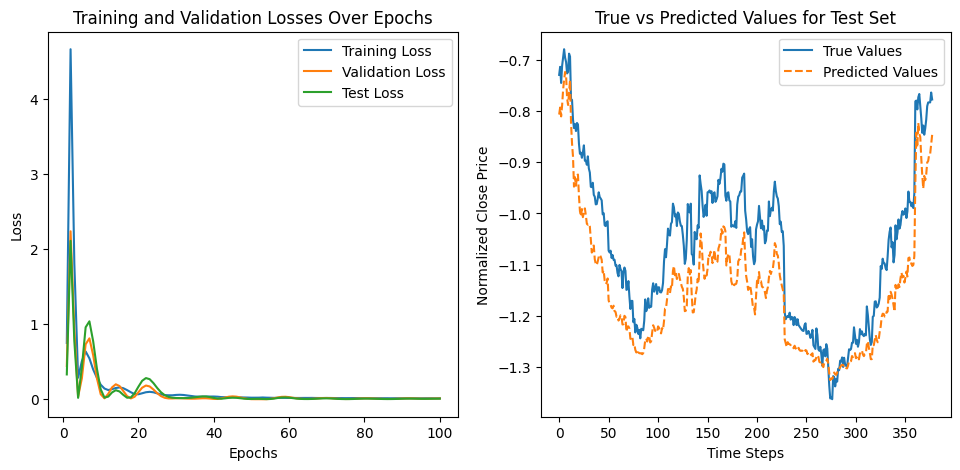

In [30]:
print(f'Final Test Loss: {test_losses[-1]:.4f}')
print()

model.eval()

with torch.no_grad():
    val_predictions = model(val_features.unsqueeze(1))
val_predictions = val_predictions.squeeze(1).cpu().numpy()
val_target_numpy = val_target.cpu().numpy()

mae_val = mean_absolute_error(val_target_numpy, val_predictions)
mse_val = mean_squared_error(val_target_numpy, val_predictions)
rmse_val = np.sqrt(mse_val)
mape_val = calculate_mape(val_target_numpy, val_predictions)

print('Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_val:.4f}')
print(f'Mean Squared Error (MSE): {mse_val:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val:.4f}')
print()

with torch.no_grad():
    test_predictions = model(test_features.unsqueeze(1))
test_predictions = test_predictions.squeeze(1).cpu().numpy()
test_target_numpy = test_target.cpu().numpy()

mae_test = mean_absolute_error(test_target_numpy, test_predictions)
mse_test = mean_squared_error(test_target_numpy, test_predictions)
rmse_test = np.sqrt(mse_test)
mape_test = calculate_mape(test_target_numpy, test_predictions)

print('Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_test:.4f}')
print(f'Mean Squared Error (MSE): {mse_test:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.4f}')

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_target_numpy, label='True Values')
plt.plot(test_predictions, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set')
plt.legend()
plt.show()